This notebook is put together by [Qingkai Kong](http://seismo.berkeley.edu/qingkaikong/) from [Berkeley Seismology Lab](http://seismo.berkeley.edu) for the 2019 SSA Machine Learning workshop. If you have any questions, feel free to contact him via kongqk@berkeley.edu. 

In [1]:
# import all the needed module
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import pandas as pd
import glob
from obspy import read
plt.style.use('seaborn-poster')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Prepare the training data

The first step is always reading in the data into a good format so that we can input into ML algorithms. 

In [2]:
training_folder = '../data/training_data_classification_regression/'
# prepare data
waveforms = []
labels = []

for item in glob.glob(training_folder + 'seismic/*.mseed'):

    # read in noise data
    st = read(item.replace('seismic', 'noise'))
    st.detrend('demean').detrend('linear')
    
    # skip the data that has less data points
    if st[0].stats.npts < 1626:
        continue
    
    data = np.c_[st[0].data, st[1].data, st[2].data]
    #data = data/data.max(axis = 0)
    waveforms.append(data)
    labels.append(0)
    
    st = read(item)
    st.detrend('demean').detrend('linear')
    data = np.c_[st[0].data, st[1].data, st[2].data]
    # let's do a simple normalize the data
    #data = data/data.max(axis = 0)
    waveforms.append(data)
    labels.append(1)
    
waveforms = np.dstack(waveforms)
y = np.array(labels)
waveforms = waveforms.T

In [3]:
waveforms.shape

(528, 3, 1626)

In [4]:
y.shape

(528,)

## Let's see some examples of noise and EQ waveforms

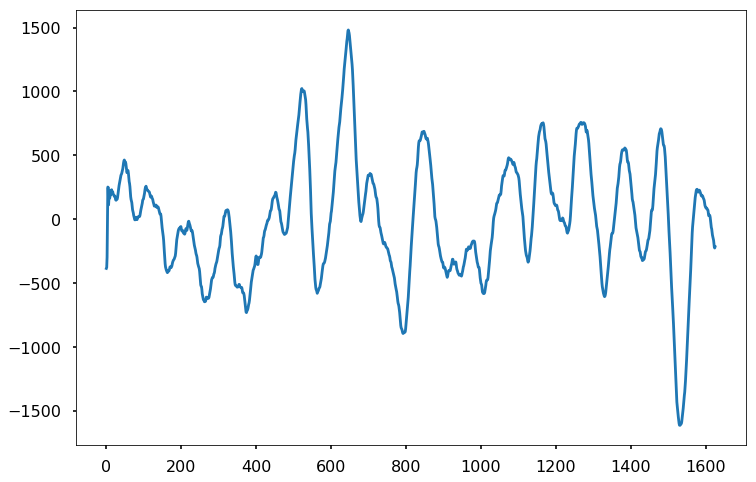

In [5]:
# Noise
plt.figure(figsize = (12, 8))
plt.plot(waveforms[2, 1, :])

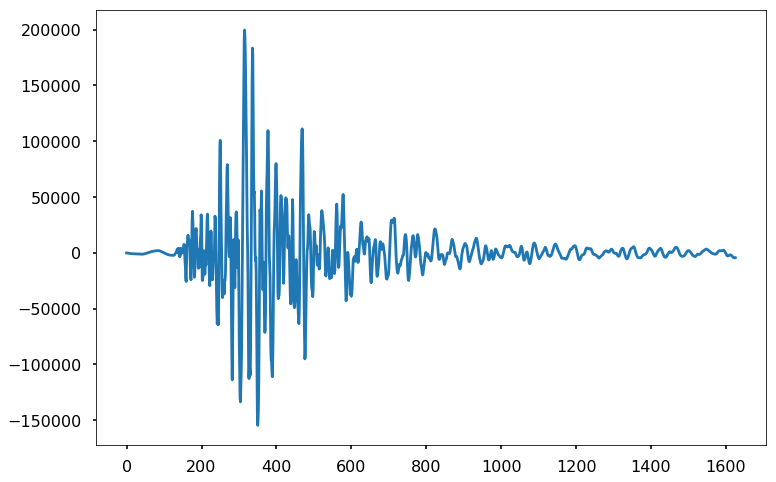

In [6]:
# EQ
plt.figure(figsize = (12, 8))
plt.plot(waveforms[31, 1, :])

In [7]:
waveforms[31, :, :].shape

(3, 1626)

## Extract features

Let's first define a function to calculate just 4 features (of course, you can calculate more, we will only use these 4 features to illustrate the main ideas). These features such as mean value, max value, standard deviation, and number of zero crossings are calculated first on each of the 3 components, and then we only keep the largest one from the 3 components. 

In [8]:
def calculate_features(data):
    
    # Similar features
    mean_amp = np.apply_along_axis(np.mean, 1, np.abs(data))
    max_amp = np.apply_along_axis(max, 1, np.abs(data))
    std_amp = np.apply_along_axis(np.std, 1, data)
    
    # useful features
    zero_crossings = lambda data: len(np.where(np.diff(np.sign(data)))[0])
    zc = np.apply_along_axis(zero_crossings, 1, data)
    
    # non-useful features at all
    duration = len(data[1, :])
    
    return max(mean_amp), max(max_amp), max(std_amp), max(zc), duration

In [9]:
# calculate all the features for each record
X = np.array(list(map(calculate_features, waveforms)))

Text(0, 0.5, 'max_amp')

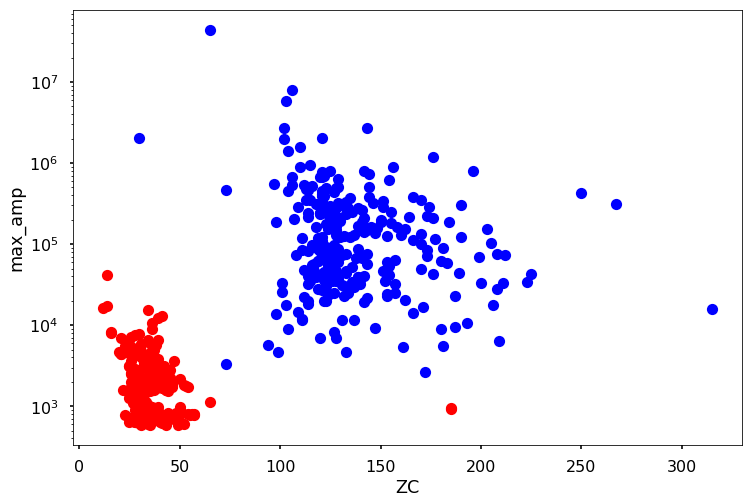

In [10]:
plt.figure(figsize = (12, 8))
for i, c in zip([0, 1], ['r', 'b']):
    ix = y == i 
    plt.plot(X[:, 3][ix], X[:, 1][ix], 'o', color = c)
    plt.yscale('log')
    
plt.xlabel('ZC')
plt.ylabel('max_amp')

Text(0, 0.5, 'mean_amp')

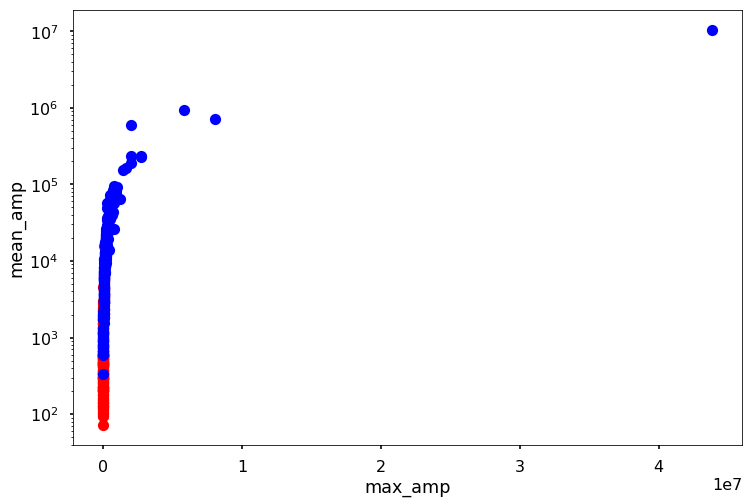

In [11]:
plt.figure(figsize = (12, 8))
for i, c in zip([0, 1], ['r', 'b']):
    ix = y == i 
    plt.plot(X[:, 1][ix], X[:, 0][ix], 'o', color = c)
    plt.yscale('log')
plt.xlabel('max_amp')
plt.ylabel('mean_amp')

## Divide training/testing dataset and preprocessing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7)

In [13]:
print(len(X_train), len(X_test))

422 106


In [14]:
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train)

## Feature selection

There are different ways to select the best subset of the features, for example, scikit-learn has various [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) methods that you can easily use for your purposes. Here we will show how we can select the subset number of features achieve our goal. 

In [15]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [16]:
# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
# Here in order to speed up, we only use the first 50 records for finding the best features
rfecv.fit(X_train_scale, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 2


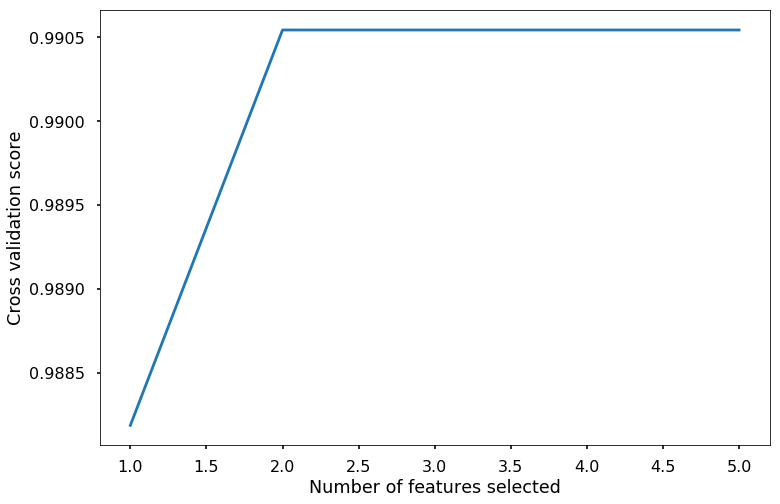

In [17]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize = (12, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [18]:
feature_names = ['mean_amp', 'max_amp', 'std_amp', 'zc', 'duration']
rfecv.ranking_

array([3, 1, 2, 1, 4])

Text(0, 0.5, 'Ranking of the features (1 means selected)')

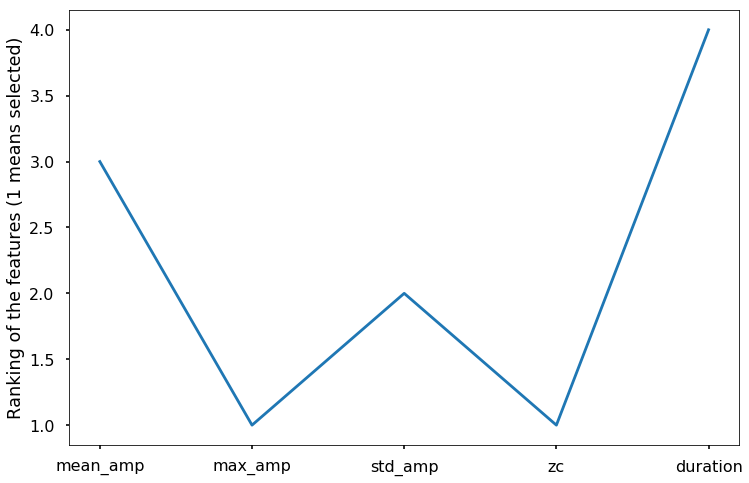

In [19]:
plt.figure(figsize = (12, 8))
plt.plot(rfecv.ranking_)
plt.xticks(range(5), feature_names)
plt.ylabel('Ranking of the features (1 means selected)')

## Train an ANN model

### Turning hyperparameters

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [21]:
X_train_select = X_train[:, [1, 3]]
X_test_select = X_test[:, [1, 3]]
# re-normalize the two column data
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train_select)
X_test_scale = standard_scaler.transform(X_test_select)

In [22]:
# Set the parameters by cross-validation
tuned_parameters = [{'hidden_layer_sizes': [(1, ), (2, ), (3, ), (4, ), (1, 1), (2, 2), (3, 3), (4, 4)],
                    'solver': ['adam', 'sgd']}]

In [23]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(MLPClassifier(max_iter = 500, early_stopping=True,validation_fraction=0.2, \
                        tol = 1e-5, n_iter_no_change = 20, learning_rate_init = 0.1, random_state =1), tuned_parameters, cv=5, \
                       scoring='%s_macro' % score)
    clf.fit(X_train_scale, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'hidden_layer_sizes': (2, 2), 'solver': 'adam'}

Grid scores on development set:

0.252 (+/-0.014) for {'hidden_layer_sizes': (1,), 'solver': 'adam'}
0.252 (+/-0.015) for {'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.993 (+/-0.019) for {'hidden_layer_sizes': (2,), 'solver': 'adam'}
0.993 (+/-0.019) for {'hidden_layer_sizes': (2,), 'solver': 'sgd'}
0.979 (+/-0.027) for {'hidden_layer_sizes': (3,), 'solver': 'adam'}
0.984 (+/-0.024) for {'hidden_layer_sizes': (3,), 'solver': 'sgd'}
0.991 (+/-0.018) for {'hidden_layer_sizes': (4,), 'solver': 'adam'}
0.986 (+/-0.023) for {'hidden_layer_sizes': (4,), 'solver': 'sgd'}
0.252 (+/-0.014) for {'hidden_layer_sizes': (1, 1), 'solver': 'adam'}
0.252 (+/-0.014) for {'hidden_layer_sizes': (1, 1), 'solver': 'sgd'}
0.995 (+/-0.012) for {'hidden_layer_sizes': (2, 2), 'solver': 'adam'}
0.991 (+/-0.017) for {'hidden_layer_sizes': (2, 2), 'solver': 'sgd'}
0.995 (+/-0

## Train and Test the model

In [24]:
# Initialize ANN classifier
mlp = MLPClassifier(hidden_layer_sizes=(2, ), max_iter = 500, learning_rate_init = 0.1, \
                    early_stopping=True, validation_fraction=0.2, solver = 'sgd', \
                    tol = 1e-5, n_iter_no_change = 20, verbose = True, random_state = 5)

# Train the classifier with the traning data
mlp.fit(X_train_scale,y_train)
y_true, y_pred = y_test, mlp.predict(X_test_scale)
print(classification_report(y_true, y_pred))

Iteration 1, loss = 0.80109638
Validation score: 0.600000
Iteration 2, loss = 0.69183886
Validation score: 0.882353
Iteration 3, loss = 0.56337878
Validation score: 1.000000
Iteration 4, loss = 0.44894872
Validation score: 1.000000
Iteration 5, loss = 0.37251174
Validation score: 1.000000
Iteration 6, loss = 0.31937013
Validation score: 1.000000
Iteration 7, loss = 0.28298976
Validation score: 1.000000
Iteration 8, loss = 0.25161410
Validation score: 1.000000
Iteration 9, loss = 0.22611573
Validation score: 1.000000
Iteration 10, loss = 0.20505904
Validation score: 1.000000
Iteration 11, loss = 0.18489890
Validation score: 1.000000
Iteration 12, loss = 0.16691964
Validation score: 1.000000
Iteration 13, loss = 0.15235095
Validation score: 1.000000
Iteration 14, loss = 0.13971131
Validation score: 1.000000
Iteration 15, loss = 0.12946594
Validation score: 1.000000
Iteration 16, loss = 0.12116170
Validation score: 1.000000
Iteration 17, loss = 0.11472953
Validation score: 1.000000
Iterat

Text(0, 0.5, 'Loss')

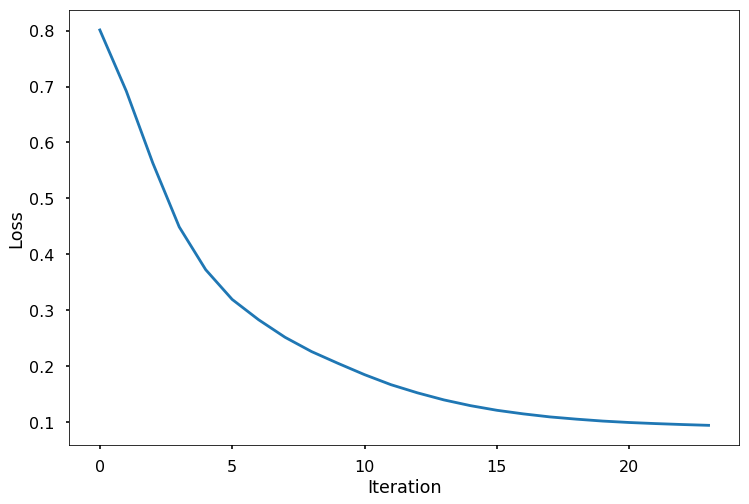

In [25]:
plt.figure(figsize = (12, 8))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Validation score')

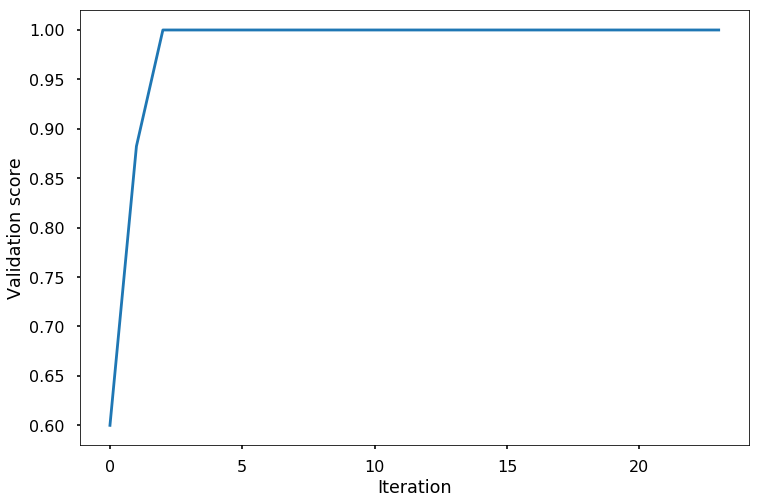

In [26]:
plt.figure(figsize = (12, 8))
plt.plot(mlp.validation_scores_)
plt.xlabel('Iteration')
plt.ylabel('Validation score')

## Feeding waveforms directly to Deep learning 

In [27]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [28]:
# prepare data
X = []
y = []
num_classes = 2

for item in glob.glob(training_folder + 'seismic/*.mseed'):

    # read in noise data
    st = read(item.replace('seismic', 'noise'))
    st.detrend('demean').detrend('linear')
    
    # skip the data that has less data points
    if st[0].stats.npts < 1626:
        continue
    
    data = np.c_[st[0].data, st[1].data, st[2].data]
    # let's do a simple normalize the data
    data = data/data.max(axis = 0)
    X.append(data)
    y.append(0)
    
    st = read(item)
    st.detrend('demean').detrend('linear')
    data = np.c_[st[0].data, st[1].data, st[2].data]
    # let's do a simple normalize the data
    data = data/data.max(axis = 0)
    X.append(data)
    y.append(1)
    
X = np.dstack(X)
y = np.array(y)
X = X.T
y = keras.utils.to_categorical(y, num_classes)

In [29]:
X.shape

(528, 3, 1626)

In [30]:
y.shape

(528, 2)

In [31]:
# input image dimensions
img_rows, img_cols = 3, 1626

In [32]:
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [33]:
X.shape

(528, 3, 1626, 1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7)

In [44]:
# define the model

inputs = Input(input_shape)
x = Conv2D(8, (1, 3), activation='relu')(inputs)
x = MaxPooling2D((1, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)
model = Model(inputs = inputs, outputs = out)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 1626, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 1624, 8)        32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 812, 8)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 812, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 19488)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                311824    
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
__________

In [45]:
batch_size = 8
epochs = 10

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# use 20% of the training data as validation
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)

Train on 337 samples, validate on 85 samples
Epoch 1/10
337/337 [==============================] - 1s 4ms/step - loss: 0.3361 - acc: 0.8368 - val_loss: 0.1193 - val_acc: 0.9765
Epoch 2/10
337/337 [==============================] - 0s 1ms/step - loss: 0.1344 - acc: 0.9347 - val_loss: 0.0834 - val_acc: 0.9765
Epoch 3/10
337/337 [==============================] - 0s 1ms/step - loss: 0.1172 - acc: 0.9555 - val_loss: 0.0970 - val_acc: 0.9529
Epoch 4/10
337/337 [==============================] - 0s 1ms/step - loss: 0.1055 - acc: 0.9674 - val_loss: 0.0890 - val_acc: 0.9765
Epoch 5/10
337/337 [==============================] - 0s 1ms/step - loss: 0.0752 - acc: 0.9703 - val_loss: 0.0781 - val_acc: 0.9765
Epoch 6/10
337/337 [==============================] - 0s 1ms/step - loss: 0.0817 - acc: 0.9792 - val_loss: 0.0774 - val_acc: 0.9765
Epoch 7/10
337/337 [==============================] - 1s 2ms/step - loss: 0.0940 - acc: 0.9703 - val_loss: 0.0898 - val_acc: 0.9765
Epoch 8/10
337/337 [===========

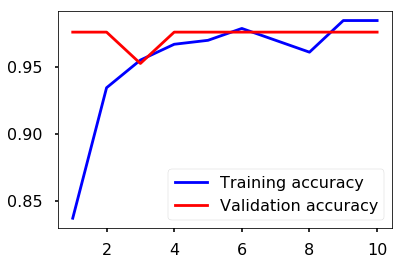

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs_axis = range(1, len(acc) + 1)
plt.plot(epochs_axis, acc, 'b', label='Training accuracy')
plt.plot(epochs_axis, val_acc, 'r', label='Validation accuracy')
plt.legend()